In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format # pandas limit to 3 decimal places
import matplotlib.pyplot as plt
from npiv import iv_simulator, custom_objectives, model_wrapper, NonparametricIV

# 0. Preliminaries

## 0.a. simulator and simulation data

In [2]:
# number of observations
n = 60000
# dimensionality of the exogenous x-variables
d = 2
# initialize simulator and create data 
ivsim = iv_simulator.IVSimulator(num_exog_x_cols=d, numpy_random_seed=0)
df = ivsim.generate_data(num_obs=n)
df['id'] = np.arange(n)
# df_test will be held out
test_cutoff = 50000
df_train = df.iloc[:test_cutoff,:]
df_test = df.iloc[test_cutoff:,:]

## 0.b. some info 
- log_sales is just a linear function of exogenous x and price
- also, expected log price is a linear function of exogenous x and instrument

In [3]:
ivsim.info()
print(df.shape)
display(df.head(10))
display(df.describe())

exogenous x columns: ['x_0', 'x_1']
endogenous x column: log_price
instrument column: instrument
y column: log_sales
log_sales is a linear function with these coefs: 
x_0          0.707
x_1          0.707
log_price   -4.000
dtype: float64
(60000, 9)


,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
0,1.764,0.400,-2.629,1.530,2.009,-0.005,2.003,-2.034,0
1,0.979,2.241,-1.413,2.277,3.507,0.060,3.567,-3.198,1
2,1.868,-0.977,-4.423,0.630,0.886,-0.008,0.878,-2.281,2
3,0.950,-0.151,-3.478,0.565,0.904,-0.043,0.861,-2.444,3
4,-0.103,0.411,-5.242,0.217,0.429,0.093,0.522,-2.570,4
5,0.144,1.454,-3.088,1.130,1.521,0.050,1.572,-3.028,5
6,0.761,0.122,-2.792,0.624,1.068,-0.046,1.022,-1.906,6
7,0.444,0.334,-1.306,0.550,2.000,-0.076,1.924,-0.377,7
8,1.494,-0.205,-2.340,0.911,1.469,0.060,1.529,-3.417,8
9,0.313,-0.854,-5.272,-0.383,-0.172,0.044,-0.128,-2.139,9


,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
count,60000.000,60000.000,60000.000,60000.000,60000.000,60000.000,60000.000,60000.000,60000.000
mean,0.001,0.005,-3.987,0.004,0.416,-0.001,0.416,-1.247,29999.500
std,0.999,0.996,1.615,1.000,1.047,0.058,1.048,3.558,17320.652
min,-4.852,-3.980,-6.800,-4.274,-4.076,-0.100,-4.130,-23.232,0.000
25%,-0.676,-0.660,-5.387,-0.672,-0.293,-0.051,-0.292,-3.096,14999.750
50%,-0.002,0.008,-3.972,0.005,0.411,-0.001,0.408,-1.340,29999.500
75%,0.673,0.674,-2.581,0.679,1.114,0.049,1.114,0.594,44999.250
max,4.286,4.242,-1.200,4.325,5.335,0.100,5.432,20.178,59999.000


## 0.c. naive regression and 2-stage least squares
- linear regression of y on x is bad due to endogeneity of price
- 2-stage least squares recovers true parameters well, because both stage1 and stage2 are linear

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
# restrict data sample to the same set we train stage2 models below for comparability purposes
df = df_train.loc[(df_train['id']>=20000)&(df_train['id']<36000)].copy()

In [6]:
# naive linear regression, suffers form endogeneity issues
x_cols = ivsim.exog_x_cols + [ivsim.endog_x_col]
y_col = ivsim.y_col
model = LinearRegression()
model.fit(df[x_cols], df[y_col])
print("estmated coefficients on log_sales:")
display(pd.concat([pd.DataFrame({'true': ivsim.log_sales_coefs}), 
                   pd.DataFrame({'naive regression':model.coef_}, index=x_cols)], axis=1)\
            .sort_index())

estmated coefficients on log_sales:


,true,naive regression
log_price,-4.000,-0.707
x_0,0.707,-1.609
x_1,0.707,-1.636


In [7]:
# now, 2-stage least squares, works quite well
# stage1
model1 = LinearRegression()
xcols1, ycol1 = ['x_0', 'x_1', 'instrument'], 'log_price'
model1.fit(df[xcols1], df[ycol1])
# print("stage1 coefs", model1.coef_)
# stage2
df['pred_log_price'] = model1.predict(df[xcols1])
model2 = LinearRegression()
xcols2, ycol2 = ['x_0', 'x_1', 'pred_log_price'], 'log_sales'
model2.fit(df[xcols2], df[ycol2])
print("estmated coefficients on log_sales:")
display(pd.concat([pd.DataFrame({'true': ivsim.log_sales_coefs}), 
                   pd.DataFrame({'2sls':model2.coef_}, index=x_cols)], axis=1)\
            .sort_index())

estmated coefficients on log_sales:


,true,2sls
log_price,-4.000,-3.936
x_0,0.707,0.675
x_1,0.707,0.648


### 1.a. some helper functions

In [8]:
#  we'll be doing some experiments where we use the true quantiles to test
#  just the second stage of the NonparmatricIV process, an in order to do that
#  we'll need a class for producing true quantiles in this synthetic example
class TrueQtlModel:
    """
    A model object for producing true quantiles of the IVSimulator model created above
    """
    elast_max = ivsim.elast_max
    elast_min = ivsim.elast_min
    log_cost_coefs = ivsim.log_cost_coefs
    exog_x_cols = ivsim.exog_x_cols
    instrument_col = ivsim.instrument_col
    def __init__(self, alpha:float):
        """
        Params:
            alpha: the quantile to predict, between 0 and 1
        """
        self.alpha = alpha
    def feature_name(self):
        return self.exog_x_cols + [self.instrument_col]
    def predict(self, df:pd.DataFrame):
        elast_qtl = self.alpha * (self.elast_max - self.elast_min) + self.elast_min 
        log_costs = iv_simulator.generate_log_costs(df[self.exog_x_cols], self.log_cost_coefs)
        log_price_qtl = iv_simulator.generate_log_optimal_prices(log_costs, elast_qtl) + df[self.instrument_col]
        return log_price_qtl

In [9]:
# we'll want to look at how the stage1 predicted quantiles look
def plot_qtls_vs_true(npiv_model:NonparametricIV, df:pd.DataFrame):
    """
    Plots the estimated stage1_models of npiv_model against the true quantiles.
    This is done by taking the stage1 model for each quantile, constructing the
    corresponding true quantile predictor, and plotting the predicted vs true.
    
    Args:
        npiv_model: NonparametricIV object with stage1_models defined
        df: a pandas dataframe that npiv_model.predict can be called on
    """
    qtl_df = npiv_model.predict_stage1(plot_df, prefix='predicted_qtl')
    ncols=4
    nrows = int(np.ceil(len(npiv_model.stage1_qtls)/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows), 
                             sharex=True, sharey=True)

    for i, alpha in enumerate(npiv_model.stage1_qtls):
        true_model = TrueQtlModel(alpha)
        true_qtls = true_model.predict(df)
        pred_col = "predicted_qtl_{:.3f}".format(alpha)
        tmp_df = pd.DataFrame({'true':true_qtls, 'predicted':qtl_df[pred_col]})
        ax = axes[i//ncols][i%ncols]
        tmp_df.plot(x='true', y = 'predicted', ax=ax, kind='scatter',
                     alpha=.3, s=3, title="{:.3f}-quantile".format(alpha), grid=True)
        # also plot the 45-degree line
        min45, max45 = tmp_df['true'].min(), tmp_df['true'].max()
        ax.plot([min45, max45], [min45, max45], color='red', alpha=.3)
    plt.suptitle("comparison of predicted vs true quantiles, with  45-degree line in red")
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

In [10]:
#helper function for plotting implied marginal effects of nonparametric IV models
def plot_performance_and_implied_margin_effects_vs_iteration(model, df_test, metric_name = 'grouped sse', 
                                                             num_grid_pts=50):
    '''
    function to compute and plot the distribution of marginal effects of a model,
        with respect to each of the model features, at the various points defined
        by df_tests    
    model should be some NonparametricIv.stage2_model when trained with 'lgb' option
    df_test should be some hold-out data
    '''
    eval_results = model.eval_results['val'][metric_name]
    num_iters = len(eval_results)
    # generate time series of marginal effects
    dfs_to_concat = []
    for num_iteration in np.linspace(1,num_iters, num_grid_pts, dtype=int):
        print(num_iteration, end=" ")
        mfx = model.marginal_effect_plots(df_test, plot=False, predict_kwargs={'num_iteration':num_iteration})
        tmp_df = mfx.groupby('feature name').describe().transpose().reset_index(level=0,drop=True)\
                    .reset_index().rename(columns={'index':'stat'})
        tmp_df.columns.name=None
        tmp_df['num_iteration'] = num_iteration
        tmp_df.set_index(['num_iteration', 'stat'], inplace=True)
        dfs_to_concat.append(tmp_df)
    desc_df = pd.concat(dfs_to_concat)
    fig, axes = plt.subplots(nrows=desc_df.shape[1]+1, ncols=1, figsize=(10, (desc_df.shape[1]+1)*1.5), sharex=True)
    # plot performance
    ax = axes[0]
    ax.grid()
    best_num_trees = np.argmin(eval_results)
    print("best iteration = {}".format(best_num_trees))
    best_perf, final_perf = eval_results[best_num_trees], eval_results[-1]
    ax.plot(eval_results)
    ax.axvline(best_num_trees, linewidth=1)
    ax.set_yscale('log')
    ax.set_title("hold-out performance ({}), blue=best={:.3E}, final={:.3E}"\
                 .format(metric_name, best_perf, final_perf))
    # plot marginal effects
    for i,c in enumerate(desc_df.columns):
        tmp_df = desc_df.loc[pd.IndexSlice[:, ['mean', 'min', 'max', '25%', '75%']],c].unstack()
        ax = axes[i+1]
        ax.grid()
        # plot the true marginal effects
        if c=='log_price_synthetic':
            true_mfx = ivsim.log_sales_coefs.loc['log_price']
        else:
            true_mfx = ivsim.log_sales_coefs.loc[c]
        ax.axhline(true_mfx, color='red', linewidth=1)
        ax.axvline(best_num_trees, color='blue', linewidth=1)
        # plot the model implied marignal effects
        ax.plot(tmp_df['mean'], color='black', linestyle='-')
        ax.plot(tmp_df['25%'], color='black', linestyle='-.')
        ax.plot(tmp_df['75%'], color='black', linestyle='-.')
        ax.set_title('mean and quartiles of marginal effects of `{}`, red = truth'.format(c))
    plt.xlabel("number of trees trained")
    plt.tight_layout()

# 1. Headline result: NonparametricIV all the way through
- nonparametrically estimate quantiles of endogenous x (`log_price`) as a function of exogenous x and instrument using LightGBM with the quantile objective
- use these estimate quantiles as input into the second stage, where we nonparametrically estimate the effect of exogenous x and `log_price` on `log_sales`, using LightGBM with a grouped L2 objective

## 1.a. Stage1 models for predicting various quantiles of `log_price`
- predicted quantiles look quite accurate
- though less accurate on the higher end

In [11]:
npiv_headline =  NonparametricIV(df=df_train,
                                 exog_x_cols=ivsim.exog_x_cols, 
                                 instrument_cols = ['instrument'],
                                 endog_x_col=ivsim.endog_x_col,
                                 y_col=ivsim.y_col,
                                 id_col='id',
                                 stage2_model_type='lgb',
                                 stage2_objective='true')

In [12]:
%%time
npiv_headline.train_stage1()

alpha=0.050
Training until validation scores don't improve for 100 rounds.
[200]	train's quantile: 0.0159327	val's quantile: 0.0162227


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:112: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[400]	train's quantile: 0.0131931	val's quantile: 0.0135859
[600]	train's quantile: 0.0127933	val's quantile: 0.0132321
[800]	train's quantile: 0.0127346	val's quantile: 0.0131967
[1000]	train's quantile: 0.0127086	val's quantile: 0.0131858
Did not meet early stopping. Best iteration is:
[1000]	train's quantile: 0.0127086	val's quantile: 0.0131858
alpha=0.150
Training until validation scores don't improve for 100 rounds.
[200]	train's quantile: 0.0375587	val's quantile: 0.0384904
[400]	train's quantile: 0.0363458	val's quantile: 0.0374518
Early stopping, best iteration is:
[491]	train's quantile: 0.0362637	val's quantile: 0.0374063
alpha=0.250
Training until validation scores don't improve for 100 rounds.
[200]	train's quantile: 0.0581568	val's quantile: 0.0597427
[400]	train's quantile: 0.0575942	val's quantile: 0.0594208
Early stopping, best iteration is:
[405]	train's quantile: 0.0575916	val's quantile: 0.0594127
alpha=0.350
Training until validation scores don't improve for 100 rou

CPU times: user 2.29 s, sys: 1.04 s, total: 3.32 s
Wall time: 1.08 s


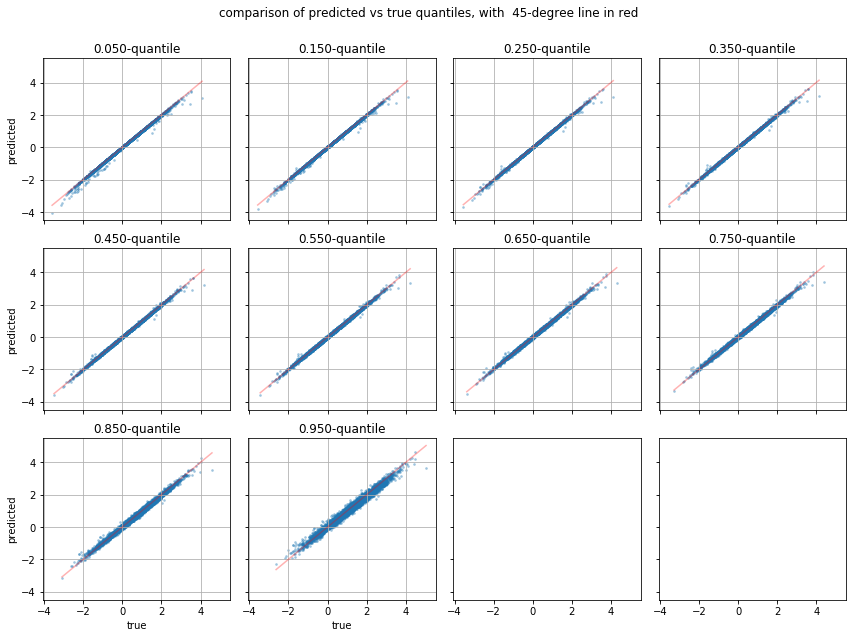

In [13]:
%%time
# look at quantiles on aggregate
plot_df = df.sample(5000)
plot_qtls_vs_true(npiv_headline, plot_df)

## 1.b. Stage2 model for estimating the impact of exogenous x and `log_price` on `log_sales`
- stage2 model's implied marginal effects are not quite ideal, but much better than ignoring endogeniety
- however, high variance in estimates
    - e.g. true coefficient on `log_price` is -4 for all observations, where we have std of around -5 for the implied marignal effects
    - this high variance is due to the estimated model being fairly jagged relative to the truth, so likely there is some smoothing that can be done to make the model a bit better behaved
- furthermore, if we were to use the validation set for early stopping, then the implied marginal effects would be quite bad
- though it doesn't seem like training for longer beyond the optimal early stopping time does much to degrade performance

In [14]:
%%time
npiv_headline.train_stage2()
model = npiv_headline.stage2_model

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	train's grouped sse: 7.14968e+06	val's grouped sse: 1.84962e+06
[2000]	train's grouped sse: 7.10376e+06	val's grouped sse: 1.86315e+06
[3000]	train's grouped sse: 7.09012e+06	val's grouped sse: 1.86858e+06
[4000]	train's grouped sse: 7.08148e+06	val's grouped sse: 1.87141e+06
[5000]	train's grouped sse: 7.07826e+06	val's grouped sse: 1.87494e+06
[6000]	train's grouped sse: 7.0753e+06	val's grouped sse: 1.87352e+06
[7000]	train's grouped sse: 7.07384e+06	val's grouped sse: 1.87676e+06
[8000]	train's grouped sse: 7.07254e+06	val's grouped sse: 1.87487e+06
[9000]	train's grouped sse: 7.07166e+06	val's grouped sse: 1.87815e+06
[10000]	train's grouped sse: 7.07163e+06	val's grouped sse: 1.87763e+06
CPU times: user 26min 18s, sys: 6.81 s, total: 26min 24s
Wall time: 8min 34s


marginal effect                                          
                        mean   std     min    25%    50%    75%    max
feature name                                                          
log_price             -3.097 5.219 -20.160 -5.719 -2.985 -0.004 19.996
x_0                   -0.024 1.668  -4.648 -1.061 -0.135  1.133  6.292
x_1                   -0.039 1.686  -7.788 -1.044  0.105  0.965  6.457

1 5000 10000 best iteration = 570
CPU times: user 2min 7s, sys: 408 ms, total: 2min 7s
Wall time: 32.3 s


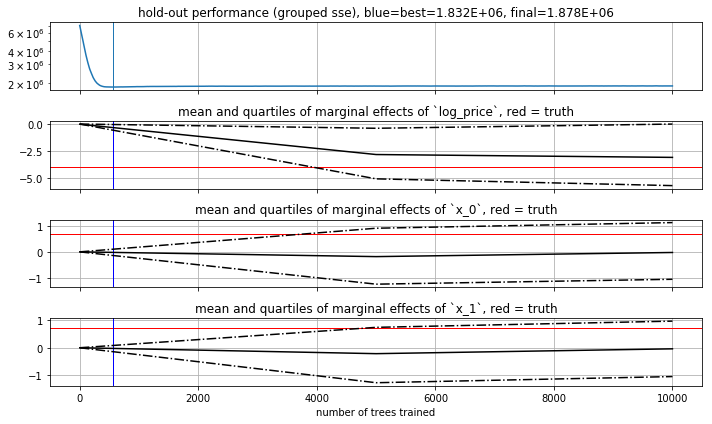

In [15]:
%%time
# print some marginal effects implied by the model
marginal_fx = model.marginal_effect_plots(df_test, plot=False)
display(marginal_fx.groupby('feature name').describe().drop(('marginal effect', 'count'), axis=1))
# and plot how the distribution of these marginal effects evolve as we train more iterations
plot_performance_and_implied_margin_effects_vs_iteration(model, df_test, metric_name='grouped sse', num_grid_pts=3)

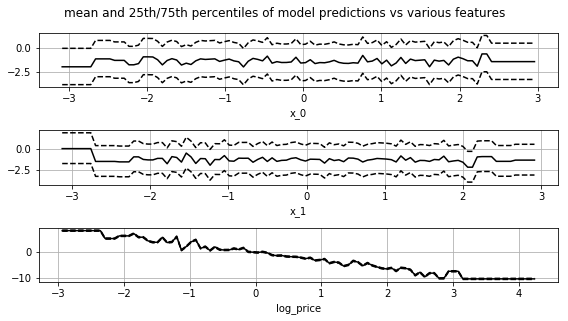

In [16]:
# plot some partial dependency plots = avgs/quantiles of output of estimated
#  stage2-model as we exogenously vary each of the features.
# in the true model, these would all be monotonic straight lines,
#  but they're clearly quite non-monotone and jagged here.
# as a result, the implied marginal effects will tend to be quite noisy
#  as the effects of each of these variables on the model is much more 
#  jagged relative to the truth
model.partial_dependency_plots(df_test)

## 1.c. re-estimate stage2 assuming linear functional form rather than doing this nonparametric LGB thing
- estimated coefficients still differ from truth, even moreso then the nonparametric LGB-based thing above
- thus, the reason for the imperfect performance is likely the first-stage

In [17]:
# take the stage1 models generated previously, and use them to initialize
#  a new NPIV model object that uses these stage1 models directly.
npiv_linear =  NonparametricIV(df=df_train,
                                 exog_x_cols=ivsim.exog_x_cols, 
                                 instrument_cols = ['instrument'],
                                 endog_x_col=ivsim.endog_x_col,
                                 y_col=ivsim.y_col,
                                 id_col='id',
                                 stage1_models = npiv_headline.stage1_models,
                                 stage2_model_type='linear',
                                 stage2_objective='true')

In [18]:
%%time
npiv_linear.train_stage2()
model = npiv_linear.stage2_model
display(pd.DataFrame({'estimated stage2 coefficients':model.coef_}, index=model.feature_name()).sort_index())

,estimated stage2 coefficients
log_price,-2.559
x_0,-0.332
x_1,-0.348


CPU times: user 16.8 s, sys: 133 ms, total: 16.9 s
Wall time: 8.93 s


In [19]:
# the data begin used to train the linear stage2 model here is the same as the one used to train
#  the stage2 model in npiv_headline, so the comparison is valid
pd.testing.assert_frame_equal(npiv_linear.stage2_data.head(), npiv_headline.stage2_data.head())

# 2. Now, instead of estimating quantiles in stage1, use the true quantiles

## 2.a. define the true stage1 quantile-generating functions

In [20]:
# now, we can construct the dict models for passing into NonparametricIV
# use the same quantiles as the model where we estimate stage1
num_qtls = 10
qtl_list = np.arange(0 , 1 , 1/num_qtls) + (1/num_qtls/2)
print(qtl_list)
true_stage1_models = {alpha : TrueQtlModel(alpha) for alpha in qtl_list}

[ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95]


## 2.b. define NPIV models, with various stage2 models/objectives

In [21]:
# linear model, upper-bound objective
npiv_lin_upper = NonparametricIV(df=df_train,
                                 exog_x_cols=ivsim.exog_x_cols, 
                                 instrument_cols = ['instrument'],
                                 endog_x_col=ivsim.endog_x_col,
                                 y_col=ivsim.y_col,
                                 stage1_models=true_stage1_models,
                                 id_col='id',
                                 stage2_model_type='linear',
                                 stage2_objective='upper')

In [22]:
# linear model, true objective
npiv_lin_true = NonparametricIV(df=df_train,
                                 exog_x_cols=ivsim.exog_x_cols, 
                                 instrument_cols = ['instrument'],
                                 endog_x_col=ivsim.endog_x_col,
                                 y_col=ivsim.y_col,
                                 stage1_models=true_stage1_models,
                                 id_col='id',
                                 stage2_model_type='linear',
                                 stage2_objective='true')

In [23]:
# LGB model, upper-bound objective
npiv_lgb_upper = NonparametricIV(df=df_train,
                                 exog_x_cols=ivsim.exog_x_cols, 
                                 instrument_cols = ['instrument'],
                                 endog_x_col=ivsim.endog_x_col,
                                 y_col=ivsim.y_col,
                                 stage1_models=true_stage1_models,
                                 id_col='id',
                                 stage2_model_type='lgb',
                                 stage2_objective='upper')

In [24]:
# LGB model, true objective
npiv_lgb_true = NonparametricIV(df=df_train,
                                 exog_x_cols=ivsim.exog_x_cols, 
                                 instrument_cols = ['instrument'],
                                 endog_x_col=ivsim.endog_x_col,
                                 y_col=ivsim.y_col,
                                 stage1_models=true_stage1_models,
                                 id_col='id',
                                 stage2_model_type='lgb',
                                 stage2_objective='true')

## 2.c. estimate stage2 for these models, using the true stage1 quantile functions

### 2.c.I.  Linear Regression, upper bound objective
- estimated coefficients are far from truth
- this is like the second stage of 2sls, except intead of using the conditional mean of `log_price`, we use a bunch of conditional quantiles
- this amounts to noising up the mean of `log_price`
- which is errors-in-variables, so clearly inconsistent
- e.g. coefficient on log_price is -4, but the estiamte is close to 0

In [25]:
%%time
npiv_lin_upper.train_stage2(force=True)
model = npiv_lin_upper.stage2_model
coef_df = pd.DataFrame({'estimated coefficients':model.coef_}, index=model.feature_name()).sort_index()
display(coef_df)

,estimated coefficients
log_price,-0.165
x_0,-1.989
x_1,-2.019


CPU times: user 119 ms, sys: 12.1 ms, total: 131 ms
Wall time: 119 ms


### 2.c.II. Linear Regression, true objective
- estimate marginal effects are close to truth
- compare this to 1.c. above, it appears that having true quantiles significantly improves performance

In [26]:
%%time
npiv_lin_true.train_stage2(force=True)
model = npiv_lin_true.stage2_model
coef_df = pd.DataFrame({'estimated coefficients':model.coef_}, index=model.feature_name()).sort_index()
display(coef_df)

,estimated coefficients
log_price,-4.166
x_0,0.839
x_1,0.807


CPU times: user 3.55 s, sys: 131 ms, total: 3.68 s
Wall time: 2.85 s


### 2.c.III. LGB, upper bound objective
- estimated marginal effects don't appear to approach true ones
- given the errors-in-variables issue discussed for the linear upper bound objective above, this is unsurprising

In [27]:
%%time
npiv_lgb_upper.train_stage2(force=True)
model = npiv_lgb_upper.stage2_model

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	train's l2: 3.64331	val's l2: 3.70104
[2000]	train's l2: 3.62046	val's l2: 3.72497
[3000]	train's l2: 3.61848	val's l2: 3.7331
[4000]	train's l2: 3.61745	val's l2: 3.73478
[5000]	train's l2: 3.61687	val's l2: 3.74149
[6000]	train's l2: 3.61661	val's l2: 3.73932
[7000]	train's l2: 3.61641	val's l2: 3.7433
[8000]	train's l2: 3.61621	val's l2: 3.74165
[9000]	train's l2: 3.6162	val's l2: 3.74251
[10000]	train's l2: 3.61613	val's l2: 3.74362
CPU times: user 2min 58s, sys: 528 ms, total: 2min 58s
Wall time: 44.9 s


marginal effect                                         
                        mean   std     min    25%    50%    75%   max
feature name                                                         
log_price             -0.175 0.469  -2.748 -0.413 -0.166  0.049 4.039
x_0                   -1.991 1.595  -7.571 -2.992 -2.005 -0.928 5.817
x_1                   -2.030 1.633 -10.190 -2.952 -1.937 -1.133 4.028

1 205 409 613 817 1021 1225 1429 1633 1837 2041 2245 2449 2653 2857 3061 3265 3470 3674 3878 4082 4286 4490 4694 4898 5102 5306 5510 5714 5918 6122 6326 6530 6735 6939 7143 7347 7551 7755 7959 8163 8367 8571 8775 8979 9183 9387 9591 9795 10000 best iteration = 794
CPU times: user 21min 8s, sys: 503 ms, total: 21min 8s
Wall time: 5min 18s


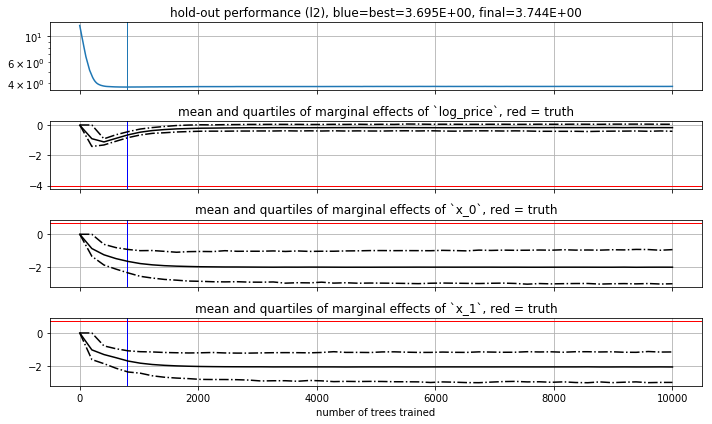

In [28]:
%%time
# print some marginal effects implied by the model
marginal_fx = model.marginal_effect_plots(df_test, plot=False)
display(marginal_fx.groupby('feature name').describe().drop(('marginal effect', 'count'), axis=1))
# and plot how the distribution of these marginal effects evolve as we train more iterations
plot_performance_and_implied_margin_effects_vs_iteration(model, df_test, metric_name='l2', num_grid_pts=50)

### 2.c.IV. LGB, true objective
- appears to work
- but still shrunk a bit towards 0 relative to the truth, or the linear true objective
- as we train many trees, implied marginal effects begin to be clustered around the truth
- comparing with 1.c. above where we used estimated quantiles, it appears that having exactly correct quantiles improves performance
- comparing with 2.c.II above where we imposed the correct linear parametric form in the second stage, it appears that not using this information causes some bias

In [29]:
%%time
npiv_lgb_true.train_stage2(force=True)
model = npiv_lgb_true.stage2_model

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	train's grouped sse: 7.14594e+06	val's grouped sse: 1.83768e+06
[2000]	train's grouped sse: 7.09679e+06	val's grouped sse: 1.8471e+06
[3000]	train's grouped sse: 7.08227e+06	val's grouped sse: 1.84739e+06
[4000]	train's grouped sse: 7.07375e+06	val's grouped sse: 1.84704e+06
[5000]	train's grouped sse: 7.06953e+06	val's grouped sse: 1.8492e+06
[6000]	train's grouped sse: 7.06661e+06	val's grouped sse: 1.84806e+06
[7000]	train's grouped sse: 7.06412e+06	val's grouped sse: 1.85062e+06
[8000]	train's grouped sse: 7.06263e+06	val's grouped sse: 1.84858e+06
[9000]	train's grouped sse: 7.06125e+06	val's grouped sse: 1.85001e+06
[10000]	train's grouped sse: 7.06024e+06	val's grouped sse: 1.85232e+06
CPU times: user 26min 12s, sys: 5.37 s, total: 26min 18s
Wall time: 8min 32s


marginal effect                                          
                        mean   std     min    25%    50%    75%    max
feature name                                                          
log_price             -3.542 5.209 -32.231 -6.802 -3.526 -0.238 21.481
x_0                    0.393 1.588  -4.314 -0.626  0.364  1.397  6.388
x_1                    0.362 1.644  -7.326 -0.579  0.388  1.412  7.147

1 205 409 613 817 1021 1225 1429 1633 1837 2041 2245 2449 2653 2857 3061 3265 3470 3674 3878 4082 4286 4490 4694 4898 5102 5306 5510 5714 5918 6122 6326 6530 6735 6939 7143 7347 7551 7755 7959 8163 8367 8571 8775 8979 9183 9387 9591 9795 10000 best iteration = 675
CPU times: user 21min 17s, sys: 423 ms, total: 21min 18s
Wall time: 5min 20s


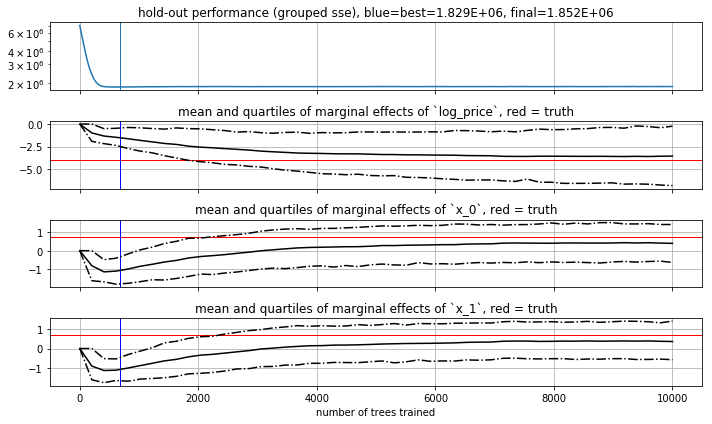

In [30]:
%%time
# print some marginal effects implied by the model
marginal_fx = model.marginal_effect_plots(df_test, plot=False)
display(marginal_fx.groupby('feature name').describe().drop(('marginal effect', 'count'), axis=1))
# and plot how the distribution of these marginal effects evolve as we train more iterations
plot_performance_and_implied_margin_effects_vs_iteration(model, df_test, metric_name='grouped sse', num_grid_pts=50)

## 2.d. impact of regularization in stage2 models
- we'll take the same setting as 2.c.IV, but up the regularization in the stage2 training
- putting in some heavy regularization causes the estimated models to become much more biased vs now having this regularization
    - e.g. log_price coef gets to -1.8 and then kind of stays there, as opposed to looking as if its trending towards -4 in 2.c.IV
- however, the hold-out performance is actually *improved* vs having this parameter set to 0
    - it's 1.824+06 here, vs 1.828e+06 in 2.c.IV
- thus, it seems like model selection based on validation performance may lead to bias in estimated parameters 

In [31]:
# take the params from above and up a reglarization parameter: 
stage2_params_with_more_regularization = npiv_lgb_true.stage2_params.copy()
stage2_params_with_more_regularization['min_gain_to_split'] = 1000
stage2_params_with_more_regularization

{'num_threads': 4,
 'num_iterations': 10000,
 'num_leaves': 5,
 'learning_rate': 0.2,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'max_delta_step': 0.1,
 'objective': None,
 'metric': None,
 'min_gain_to_split': 1000}

In [32]:
# now initialize with these stage2 params, stil using the true quantiles in stage1
npiv_lgb_true_reg = NonparametricIV(df=df_train,
                                 exog_x_cols=ivsim.exog_x_cols, 
                                 instrument_cols = ['instrument'],
                                 endog_x_col=ivsim.endog_x_col,
                                 y_col=ivsim.y_col,
                                 stage1_models=true_stage1_models,
                                 id_col='id',
                                 stage2_model_type='lgb',
                                 stage2_objective='true',
                                 stage2_params=stage2_params_with_more_regularization)

In [33]:
%%time
npiv_lgb_true_reg.train_stage2()
model = npiv_lgb_true_reg.stage2_model

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	train's grouped sse: 7.18985e+06	val's grouped sse: 1.82412e+06
[2000]	train's grouped sse: 7.18985e+06	val's grouped sse: 1.82412e+06
[3000]	train's grouped sse: 7.18985e+06	val's grouped sse: 1.82412e+06
[4000]	train's grouped sse: 7.18985e+06	val's grouped sse: 1.82412e+06
[5000]	train's grouped sse: 7.18985e+06	val's grouped sse: 1.82412e+06
[6000]	train's grouped sse: 7.18985e+06	val's grouped sse: 1.82412e+06
[7000]	train's grouped sse: 7.18985e+06	val's grouped sse: 1.82412e+06
[8000]	train's grouped sse: 7.18985e+06	val's grouped sse: 1.82412e+06
[9000]	train's grouped sse: 7.18985e+06	val's grouped sse: 1.82412e+06
[10000]	train's grouped sse: 7.18985e+06	val's grouped sse: 1.82412e+06
CPU times: user 24min 18s, sys: 5.77 s, total: 24min 24s
Wall time: 8min 8s


marginal effect                                        
                        mean   std    min    25%    50%    75%   max
feature name                                                        
log_price             -1.848 1.149 -6.374 -2.553 -1.800 -1.087 1.376
x_0                   -0.812 1.117 -4.000 -1.512 -0.816 -0.076 4.190
x_1                   -0.846 1.088 -7.400 -1.400 -0.769 -0.218 3.400

1 205 409 613 817 1021 1225 1429 1633 1837 2041 2245 2449 2653 2857 3061 3265 3470 3674 3878 4082 4286 4490 4694 4898 5102 5306 5510 5714 5918 6122 6326 6530 6735 6939 7143 7347 7551 7755 7959 8163 8367 8571 8775 8979 9183 9387 9591 9795 10000 best iteration = 658
CPU times: user 2min 37s, sys: 460 ms, total: 2min 37s
Wall time: 40.8 s


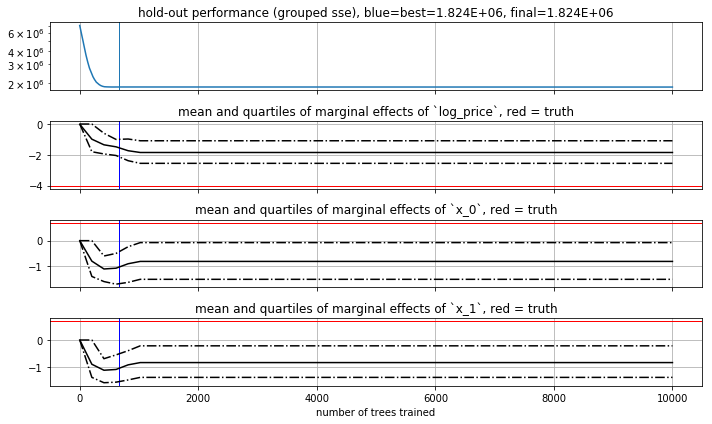

In [34]:
%%time
# print some marginal effects implied by the model
marginal_fx = model.marginal_effect_plots(df_test, plot=False)
display(marginal_fx.groupby('feature name').describe().drop(('marginal effect', 'count'), axis=1))
# and plot how the distribution of these marginal effects evolve as we train more iterations
plot_performance_and_implied_margin_effects_vs_iteration(model, df_test, metric_name='grouped sse', num_grid_pts=50)

In [35]:
# note that the stage2 data used for 2.c.iv and here are the same,
# so that validation set performance
pd.testing.assert_frame_equal(npiv_lgb_true.stage2_data, npiv_lgb_true_reg.stage2_data)

## 2.e. impact of quantile noise on stage2 models
- add a little bit of noise to the true stage1 quantiles (sdev=.1)
- performance degrades somewhat relative no noise in stage1 in 2.c.IV
- performance degrades dramatically if you add even more noise (sdev=1)

In [36]:
class TrueQtlModelWithNoise(TrueQtlModel):
    """
    class for producing noised-up versions of true quantile models
    """
    def __init__(self, sigma:float, *args, **kwargs):
        """
        Params:
            sigma: sdev of the gaussian noise to add to true quantiles
        """
        self.sigma = sigma
        super().__init__(*args, **kwargs)
    def predict(self, df:pd.DataFrame):
        log_price_qtl = super().predict(df)
        log_price_qtl_plus_noise = log_price_qtl + np.random.normal(scale=self.sigma, size=len(log_price_qtl))
        return log_price_qtl_plus_noise

# do a quick test to make sure that this works
tmp_true_model = TrueQtlModel(alpha=.5)
tmp_noisy_model =  TrueQtlModelWithNoise(sigma=1, alpha=.5)
tmp_comp_df = pd.DataFrame({
    'true': tmp_true_model.predict(df_test),
    'noisy': tmp_noisy_model.predict(df_test),
})
# variance of noisy is approx 1 more that of true, as expected
display(tmp_comp_df.head())
display(tmp_comp_df.describe())

,true,noisy
50000,0.819,1.746
50001,-0.018,0.664
50002,-0.267,-0.884
50003,-0.682,-1.876
50004,0.987,0.166


,true,noisy
count,10000.000,10000.000
mean,0.301,0.326
std,1.001,1.408
min,-3.570,-5.869
25%,-0.378,-0.620
50%,0.314,0.336
75%,0.967,1.280
max,4.404,5.446


In [37]:
# quick function for testing the impact of noisy stage1 model on stage2 estimates
def test_noise_stage1(sigma):
    # construct some noised-up quantile stage1 modes, as above
    # use the same quantiles as everything else above
    num_qtls = 10
    qtl_list = np.arange(0 , 1 , 1/num_qtls) + (1/num_qtls/2)
    print(qtl_list)
    noisy_stage1_models = {alpha : TrueQtlModelWithNoise(sigma=sigma,alpha=alpha) for alpha in qtl_list}

    # ok, now initialize a model with these noised up stage1 models
    # everything is the same  as npiv_lgb_true, above, except stgae1 is now noisy
    npiv_lgb_true_stage1noisy = NonparametricIV(df=df_train,
                                                 exog_x_cols=ivsim.exog_x_cols, 
                                                 instrument_cols = ['instrument'],
                                                 endog_x_col=ivsim.endog_x_col,
                                                 y_col=ivsim.y_col,
                                                 stage1_models=noisy_stage1_models,
                                                 id_col='id',
                                                 stage2_model_type='lgb',
                                                 stage2_objective='true')
    npiv_lgb_true_stage1noisy.train_stage2(force=True)
    model = npiv_lgb_true_stage1noisy.stage2_model
    # print some marginal effects implied by the model
    marginal_fx = model.marginal_effect_plots(df_test, plot=False)
    display(marginal_fx.groupby('feature name').describe().drop(('marginal effect', 'count'), axis=1))
    # and plot how the distribution of these marginal effects evolve as we train more iterations
    plot_performance_and_implied_margin_effects_vs_iteration(model, df_test, metric_name='grouped sse', num_grid_pts=50)
    return npiv_lgb_true_stage1noisy

[ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95]


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	train's grouped sse: 7.15101e+06	val's grouped sse: 1.84094e+06
[2000]	train's grouped sse: 7.11224e+06	val's grouped sse: 1.85258e+06
[3000]	train's grouped sse: 7.10316e+06	val's grouped sse: 1.85189e+06
[4000]	train's grouped sse: 7.09856e+06	val's grouped sse: 1.85078e+06
[5000]	train's grouped sse: 7.09639e+06	val's grouped sse: 1.85228e+06
[6000]	train's grouped sse: 7.09476e+06	val's grouped sse: 1.85197e+06
[7000]	train's grouped sse: 7.09344e+06	val's grouped sse: 1.85334e+06
[8000]	train's grouped sse: 7.09293e+06	val's grouped sse: 1.853e+06
[9000]	train's grouped sse: 7.09233e+06	val's grouped sse: 1.85414e+06
[10000]	train's grouped sse: 7.0916e+06	val's grouped sse: 1.85232e+06


marginal effect                                          
                        mean   std     min    25%    50%    75%    max
feature name                                                          
log_price             -2.872 4.235 -18.689 -5.152 -2.933 -0.285 11.978
x_0                   -0.127 1.571  -4.480 -1.136 -0.191  0.899  6.530
x_1                   -0.162 1.621  -7.465 -1.113 -0.124  0.835  5.913

1 205 409 613 817 1021 1225 1429 1633 1837 2041 2245 2449 2653 2857 3061 3265 3470 3674 3878 4082 4286 4490 4694 4898 5102 5306 5510 5714 5918 6122 6326 6530 6735 6939 7143 7347 7551 7755 7959 8163 8367 8571 8775 8979 9183 9387 9591 9795 10000 best iteration = 631
CPU times: user 47min 44s, sys: 6.6 s, total: 47min 50s
Wall time: 13min 59s


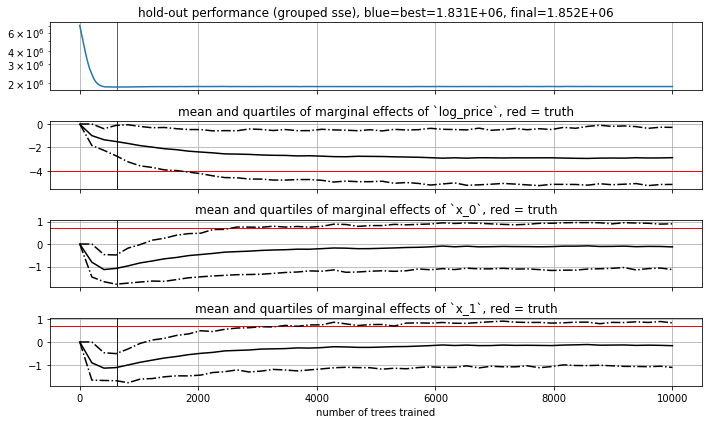

In [38]:
%%time
# 2.e.I. try a little noise
npiv_lgb_true_stage1noisy_alittle = test_noise_stage1(.1)

[ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95]


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	train's grouped sse: 7.23231e+06	val's grouped sse: 1.85482e+06
[2000]	train's grouped sse: 7.19338e+06	val's grouped sse: 1.88401e+06
[3000]	train's grouped sse: 7.18571e+06	val's grouped sse: 1.88488e+06
[4000]	train's grouped sse: 7.18092e+06	val's grouped sse: 1.88878e+06
[5000]	train's grouped sse: 7.17832e+06	val's grouped sse: 1.89093e+06
[6000]	train's grouped sse: 7.17666e+06	val's grouped sse: 1.89037e+06
[7000]	train's grouped sse: 7.17532e+06	val's grouped sse: 1.89185e+06
[8000]	train's grouped sse: 7.17422e+06	val's grouped sse: 1.89335e+06
[9000]	train's grouped sse: 7.1733e+06	val's grouped sse: 1.8935e+06
[10000]	train's grouped sse: 7.17315e+06	val's grouped sse: 1.89235e+06


marginal effect                                          
                        mean   std     min    25%    50%    75%    max
feature name                                                          
log_price             -0.130 3.676 -11.505 -2.466 -0.174  2.201 12.881
x_0                   -2.040 1.642  -7.946 -3.151 -2.098 -0.946  5.815
x_1                   -2.080 1.672  -9.932 -3.042 -1.984 -1.163  4.084

1 205 409 613 817 1021 1225 1429 1633 1837 2041 2245 2449 2653 2857 3061 3265 3470 3674 3878 4082 4286 4490 4694 4898 5102 5306 5510 5714 5918 6122 6326 6530 6735 6939 7143 7347 7551 7755 7959 8163 8367 8571 8775 8979 9183 9387 9591 9795 10000 best iteration = 795
CPU times: user 50min 43s, sys: 6.14 s, total: 50min 49s
Wall time: 14min 43s


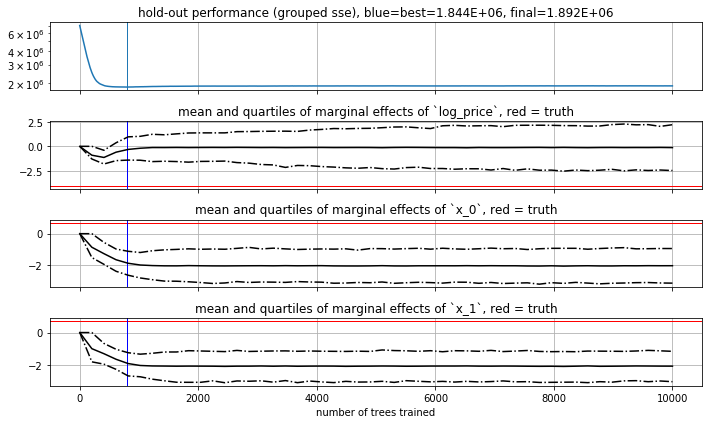

In [39]:
%%time
# 2.e.II. try a lot of noise
npiv_lgb_true_stage1noisy_alot = test_noise_stage1(1)

## 2.f. comparing true and predicted quantiles in more depth on an item level
- predicted quantiles are naturally not as centered 
- but overall look quite close to true ones

In [ ]:
# check that the dataframes we'll be combinine areidentical except for the log_price column
#  which is generated either via the trained quantile models or the true ones
pd.testing.assert_frame_equal(npiv_headline.stage2_data.drop('log_price',axis=1),
                             npiv_lgb_true.stage2_data.drop('log_price',axis=1))

In [ ]:
# now combine them and rename the log_price columns
df_qtl_real_pred = npiv_lgb_true.stage2_data.rename(columns={'log_price':'log_price_true'}).copy()
df_qtl_real_pred['log_price_pred'] = npiv_headline.stage2_data['log_price']
display(df_qtl_real_pred.head())
# compute mean and sd for each id (i.e. across all quantiles)
id_summary_df = df_qtl_real_pred.groupby('id')[['log_price_true', 'log_price_pred']].agg(['mean', 'std'])
display(id_summary_df.head())

In [ ]:
# plot true vs predicted means
id_summary_df.plot(('log_price_true', 'mean'), ('log_price_pred', 'mean'), kind='scatter', grid=True, alpha=.2)
# and quantiles
id_summary_df.plot(('log_price_true', 'std'), ('log_price_pred', 'std'), kind='scatter', grid=True, alpha=.2)

In [ ]:
# averaged over all IDs, means and varainces of the of the log prices
#  looked quite similar between the real and predicted quantiles
# though for the std, the true quantiles exhibit zero variation in the std,
#  whereas the predicted ones appear to be much more variable across observations
display(id_summary_df.describe())

In [ ]:
# slight negative correlation between std of predicted quantiles and mean of true quantiles
corr = id_summary_df[[('log_price_true', 'mean'), ('log_price_pred', 'std')]].corr().iloc[0,1]
id_summary_df.plot(('log_price_true', 'mean'), ('log_price_pred', 'std'), kind='scatter', grid=True, alpha=.2,
                   title="correlation = {:.3f}".format(corr))